# Setup

In [ ]:
!pip install rasterio torch pillow scikit-image pytorch-lightning segmentation-models-pytorch albumentations tensorboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=40c9493d0048f9983b1040d205e4443c59efd30d30b4006243c9a2f6569fd56a
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=0dd2856b2132b424e60e5a5617c514cd7894282

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
import os
import torch
import glob
import time
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import segmentation_models_pytorch as smp
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, jaccard_score
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import random
import matplotlib.colors as mcolors
from skimage.io import imread, imshow

from skimage.io import imread
import albumentations as A
from typing import List

import datetime

In [ ]:
def set_all_seeds(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_all_seeds()

Random seed set as 42


In [ ]:
# DATASET
dataset_dir = "drive/MyDrive/Eversea/Mangrove Dataset/mangrove_dataset_2020/"
# ADJUST THESE 2 VALUES DEPENDING ON THE TRAINING TIME
# 50 SAMPLES FOR TRAINING AND TESTING SEEMS REASONABLE => TO CONFIRM !!
train_test_split = 0.5
n_samples_per_zone = 50
n_zones = 10
# Order of bands : B, G, R, nir, nir_vegetation, swir, ndvi, ndwi, ndmi
# Keep all bands by default and reduce if training takes too long (keep a minima the first 4 + ndvi and ndmi)
bands_to_keep = list(range(9))

# MODEL
num_channels = len(bands_to_keep)
num_classes = 1 # Mangrove class
encoder_name = "resnet50"
encoder_weights = None
activation = 'sigmoid' # Mangrove vs Non-Mangrove
use_augmentation = True
name_model = "PAN-Resnet50"
model_save_path = f'/content/drive/MyDrive/Eversea/Mangrove Dataset/Model/{name_model}/epochs'
save_interval = 1
encoder_depth = 3
decoder_channels=(256, 64, 64)

# TRAINING
batch_size = 32
learning_rate = 0.0001
num_epochs = 100


# COMPUTATION & PRINTS (PYTORCH LIGHTNING)
accelerator = 'gpu'
strategy =  'auto'#'ddp' if multiple GPUs otherwise leave emtpy if single GPU training
num_nodes = 1
gpus_per_node = 1
num_workers = 1
enable_progress_bar = True
progress_rate = 10

# Display random examples

In [ ]:
def get_all_file_paths(folder_path):
    # Use glob to get all file paths in the folder and its subfolders
    file_paths = glob.glob(os.path.join(folder_path, '**'), recursive=True)
    # Filter out directories from the list
    file_paths = [file_path for file_path in file_paths if os.path.isfile(file_path)]
    return file_paths

def get_all_file_paths_by_zone(folder_path, n_zones):
    file_paths = glob.glob(os.path.join(folder_path, '**'), recursive=True)
    file_paths_by_zone = {i:[] for i in range(n_zones)}
    for file_path in file_paths:
      if os.path.isfile(file_path):
        zone_id = int(file_path.split("/")[-1][0])
        file_paths_by_zone[zone_id].append(file_path)
    return file_paths_by_zone

# get_all_file_paths_by_zone((os.path.join(dataset_dir, "sentinel_images/")), 10)

In [ ]:
project_location = "drive/MyDrive/Eversea/Mangrove Dataset/"
path_to_2020_sentinel_images_folder = project_location + "mangrove_dataset_2020/sentinel_images/"
path_to_2020_masks_folder = project_location + "mangrove_dataset_2020/masks/"

images = sorted(get_all_file_paths(path_to_2020_sentinel_images_folder))
masks = sorted(get_all_file_paths(path_to_2020_masks_folder))

In [ ]:
cmap_model = mcolors.ListedColormap(['none', 'red'])
multi_factor = 5/1e4
clip_range = (0,1)

def display_samples(images, masks, nb_samples: list, palette=cmap_model) -> None:
    indices = random.sample(range(0, len(images)), nb_samples)
    fig, axs = plt.subplots(nrows = nb_samples, ncols = 3, figsize = (20, nb_samples * 6)); fig.subplots_adjust(wspace=0.0, hspace=0.01)
    fig.patch.set_facecolor('black')
    for u, idx in enumerate(indices):
        rgb_im = imread(images[idx])[:,:, [2, 1, 0]]
        mk = np.load(masks[idx])
        # with rasterio.open(masks[idx], 'r') as f:
        #     mk = f.read([1])
        #     mk = convert_to_color(mk[0], palette=palette)
        axs = axs if isinstance(axs[u], np.ndarray) else [axs]
        ax0 = axs[u][0] ; ax0.imshow(np.clip(rgb_im*multi_factor, *clip_range));ax0.axis('off')
        ax1 = axs[u][1] ; ax1.imshow(mk, cmap=cmap_model, interpolation='nearest') ;ax1.axis('off')
        ax2 = axs[u][2] ; ax2.imshow(np.clip(rgb_im*multi_factor, *clip_range)); ax2.imshow(mk, cmap=cmap_model, interpolation='nearest', alpha=0.3); ax2.axis('off')
        if u == 0:
            ax0.set_title('RGB Image', size=16,fontweight="bold",c='w')
            ax1.set_title('Ground Truth Mask', size=16,fontweight="bold",c='w')
            ax2.set_title('Overlay Image & Mask', size=16,fontweight="bold",c='w')

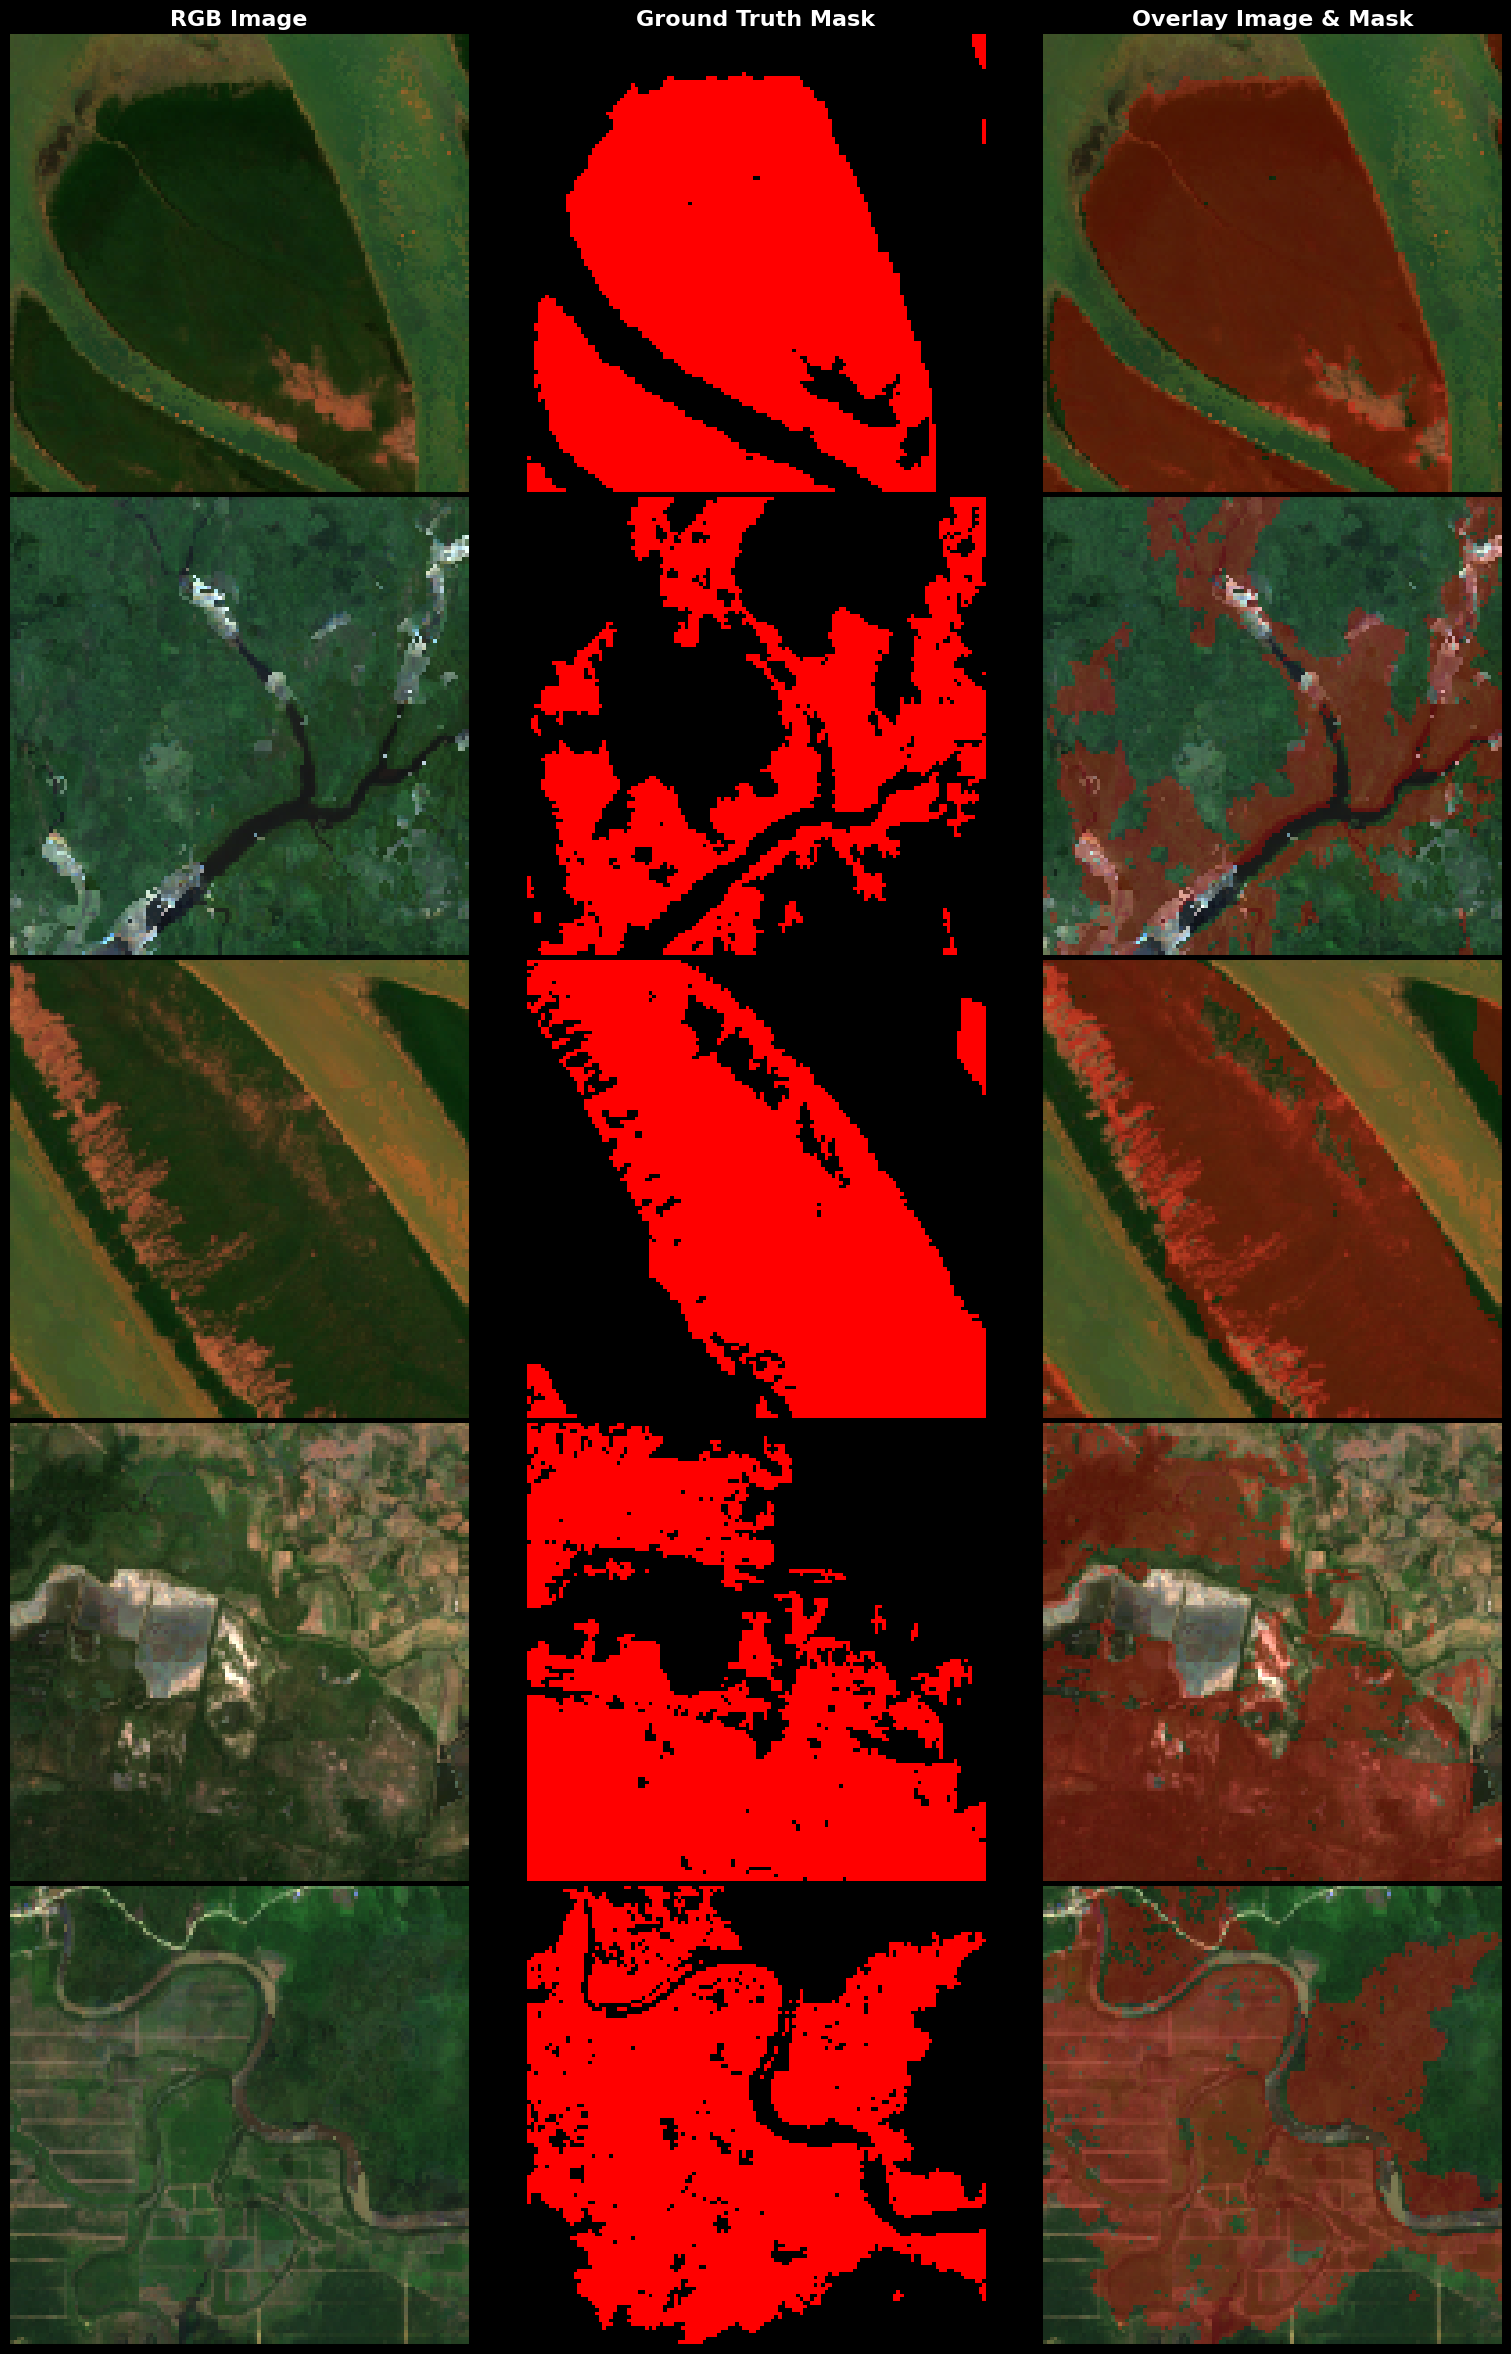

In [ ]:
display_samples(images, masks, nb_samples=5)

# Mangrove Dataset

In [ ]:
class MangroveSegmentationDataset(Dataset):
    def __init__(self, paths:List, bands_to_keep = None, use_augmentation=False):
        """
        Initialize the dataset for Mangrove segmentation.
        """
        self.paths = paths
        random.shuffle(self.paths)  # Shuffle the entire list of paths
        self.bands_to_keep = bands_to_keep
        self.use_augmentation = use_augmentation

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        """
        Get the image and mask for a given index.

        Args:
            idx (int): Index of the sample to fetch.

        Returns:
            tuple: Tuple containing the image and mask tensors.
        """
        # Construct file paths for the image and mask
        image_path, mask_path = self.paths[idx]

        # Load image and mask
        try:
            # only keep requested bands
            image = imread(image_path)[:,:,self.bands_to_keep].astype('float32') # Ensure the dtype for augmentations
            mask = np.load(mask_path)
        except Exception as e:
            print(f"Error loading image/mask at index {idx}: {e}")
            return None, None

        # Apply transforms
        if self.use_augmentation == True:
            augmentation_transform = A.Compose([A.VerticalFlip(p=0.5),
                               A.HorizontalFlip(p=0.5),
                               A.RandomRotate90(p=0.5),
                               A.RandomResizedCrop(128, 128, p=1),
                               ])
            sample = {"image" : image, "mask": mask}
            transformed_sample = augmentation_transform(**sample)
            image, mask = transformed_sample["image"].copy(), transformed_sample["mask"].copy()

       # Normalize image
        post_processed_image = (image-image.min())/(image.max()-image.min() + 1e-8) # Normalize image channel by channel

        if self.use_augmentation == True:
            # Add Gaussian Noise (to the normalized image because values need to be between 0 and 1)
            gaussian_transform = A.GaussNoise(var_limit=(0.002), p=0.5)  # Adjust var_limit for the strength of noise
            post_processed_image = gaussian_transform(image=post_processed_image)["image"].copy()

         # Convert to PyTorch tensors
        image_tensor = torch.as_tensor(post_processed_image.transpose(2, 0, 1), dtype=torch.float) # Images have to be in Channel*Height*Width (CHW) format but we read them as HWC
        mask_tensor = torch.as_tensor(np.expand_dims(mask, axis=0), dtype=torch.float) # Add a dimension to have masks in the CHW (C=1) format and not HW

        return image_tensor, mask_tensor

In [ ]:
def get_train_test_paths_by_zone(dataset_dir, train_test_split, n_samples_per_zone, n_zones):

    # Train/Test split on shuffled indexes in the range(len(image_paths))

    if n_samples_per_zone:
      # Only keep n_samples_per_zone samples for the  benchmarking
      image_paths_by_zone = get_all_file_paths_by_zone(os.path.join(dataset_dir, "sentinel_images/"), n_zones)
      mask_paths_by_zone = get_all_file_paths_by_zone(os.path.join(dataset_dir, "masks/"), n_zones)
      full_paths_train = []
      full_paths_test = []

      for zone_id in range(n_zones):
        image_paths, mask_paths = image_paths_by_zone[zone_id], mask_paths_by_zone[zone_id]
        assert len(image_paths) == len(mask_paths), f"Unequal number of images and masks for zone {zone_id}"
        sample_indexes = list(range(len(image_paths)))
        random.shuffle(sample_indexes)
        selected_indices = random.sample(sample_indexes, n_samples_per_zone)
        n_train_samples = int(n_samples_per_zone * train_test_split)
        train_indices, test_indices = selected_indices[:n_train_samples], selected_indices[n_train_samples:]
        full_paths_train += [(image_paths[idx], mask_paths[idx]) for idx in train_indices]
        full_paths_test += [(image_paths[idx], mask_paths[idx]) for idx in test_indices]

      return full_paths_train, full_paths_test


def get_train_test_paths(dataset_dir, train_test_split):

    image_paths = sorted(get_all_file_paths(os.path.join(dataset_dir, "sentinel_images/")))
    mask_paths = sorted(get_all_file_paths(os.path.join(dataset_dir, "masks/")))
    assert len(image_paths) == len(mask_paths), f"Number of images ({len(image_paths)}) and masks ({len(mask_paths)}) should be equal"
    n_samples = len(image_paths)
    print(f"Total number of selected samples = {n_samples}")
    n_train_samples = int(n_samples * train_test_split)
    samples_indexes = list(range(n_samples))
    random.shuffle(samples_indexes)
    train_indices, test_indices = samples_indexes[:n_train_samples], samples_indexes[n_train_samples:]
    assert (len(train_indices + test_indices)) == n_samples, f"Sum of train ({len(train_indices)}) and test ({len(test_indices)}) should be equal to {n_samples}"


    full_paths_train += [(image_paths[idx], mask_paths[idx]) for idx in train_indices]
    full_paths_test += [(image_paths[idx], mask_paths[idx]) for idx in test_indices]

    return full_paths_train, full_paths_test


# def compute_stats_from_images(image_paths):
#     """
#     Compute the total mean and standard deviation for each channel of all images in a folder by loading images one by one.

#     Args:
#     - image_paths: paths to the images

#     Returns:
#     - total_mean: numpy array containing the total mean values for each channel across all images in the folder
#     - total_std: numpy array containing the total standard deviation values for each channel across all images in the folder
#     """

#     # Initialize variables to store running sum and squared sum
#     channel_sum = np.zeros(9)
#     channel_sum_sq = np.zeros(9)
#     total_images = 0

#     # Iterate over the images in the folder
#     for image_path in image_paths:
#         # Load the image
#         print(f"Loading image: {image_path}")
#         image = imread(image_path)

#         # Update running sum and squared sum for each channel
#         channel_sum += np.mean(image, axis=(0, 1))
#         channel_sum_sq += np.mean(image ** 2, axis=(0, 1))
#         # print(f"Channel sum: {channel_sum}")
#         # print(f"Channel sum sq: {channel_sum_sq}")
#         print(f"{total_images}/{len(image_paths)}")

#         total_images += 1

#         # if (total_images -1) % 50 == 0:
#         #   print(f"{total_images}/{len(image_paths)}")

#     # Compute total mean and standard deviation across all images
#     total_mean = channel_sum / total_images
#     total_std = ((channel_sum_sq / (total_images)) - (total_mean ** 2)) ** 0.5

#     return total_mean, total_std

In [ ]:
full_paths_train, full_paths_test = get_train_test_paths_by_zone(dataset_dir, train_test_split, n_samples_per_zone, n_zones)
print(len(full_paths_train), len(full_paths_test))

dataset_train = MangroveSegmentationDataset(full_paths_train, bands_to_keep, use_augmentation=True)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_test = MangroveSegmentationDataset(full_paths_test, bands_to_keep, use_augmentation=False)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

250 250


# Model

In [ ]:
model = smp.PAN(
    encoder_output_stride=16,
    upsampling=4,
    encoder_name = encoder_name,
    #decoder_channels=decoder_channels,
    in_channels=num_channels,
    decoder_channels=512,
    activation = activation,
    classes=1,
)

In [ ]:
def count_parameters(model):
    # Number of parameters in millions
    return sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6

count_parameters(model)
# 32.54 for resnet50, 24.45 for resnet34, 14.34 for resnet18

34.785352

# Training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.5, verbose=False)
model.to(device)

Using cuda:0 device


PAN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(9, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [ ]:
import torch
import numpy as np
from sklearn.metrics import f1_score, jaccard_score, accuracy_score
from tqdm import tqdm
import time
import datetime
import os

def train_final_model(model, total_training_loader, total_test_loader, n_epochs, optimizer, scheduler, criterion, device, model_save_path, save_interval):
    """
    Trains a PyTorch model.

    Args:
    - model (nn.Module): the PyTorch model to be trained
    - total_training_loader (DataLoader): DataLoader containing the training set
    - total_test_loader (DataLoader): DataLoader containing the test set
    - n_epochs (int): number of training epochs
    - optimizer (optim.Optimizer): the optimizer to use for training
    - scheduler (optim.lr_scheduler): the scheduler used for training
    - criterion (nn.Module): the loss function to use for training
    - device (str): device to run the model on (e.g. 'cpu' or 'cuda')
    - model_save_path (str): path to the folder where the model will be saved
    - save_interval (int): save the model every save_interval epochs

    Returns:
    - mean_loss_train (list): mean loss per epoch for the training set
    - mean_f1_train (list): mean F1 score per epoch for the training set
    - mean_iou_train (list): mean IOU per epoch for the training set
    - mean_accuracy_train (list): mean accuracy per epoch for the training set
    - mean_loss_test (list): mean loss per epoch for the test set
    - mean_f1_test (list): mean F1 score per epoch for the test set
    - mean_iou_test (list): mean IOU per epoch for the test set
    - mean_accuracy_test (list): mean accuracy per epoch for the test set
    - elapsed_time (float): total training time
    - best_model_filename (str): filename of the best model
    - best_mean_iou_test (float): best IOU score achieved on the test set
    """

    # Initialize lists to keep track of metrics
    mean_loss_train = []
    mean_f1_train = []
    mean_iou_train = []
    mean_accuracy_train = []

    mean_loss_test = []
    mean_f1_test = []
    mean_iou_test = []
    mean_accuracy_test = []

    best_mean_iou_test = -np.inf
    best_model_filename = None

    start_time = time.time()

    # Loop over epochs
    for it in range(1, n_epochs + 1):

        print(f"EPOCH {it}")

        print("Training...")

        # Initialize lists to keep track of train metrics for this epoch
        train_loss = []
        train_f1 = []
        train_iou = []
        train_accuracy = []

        # Set model to train mode
        model.train()

        # Loop over training data
        for images, targets in tqdm(total_training_loader):

            # Move data to device
            images, targets = images.to(device), targets.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization step
            loss.backward()
            optimizer.step()

            # Append loss to train_loss list
            train_loss.append(loss.item())

            # Calculate F1 score
            preds_binary = (outputs > 0.5).float()
            f1 = f1_score(targets.cpu().numpy().flatten(), preds_binary.cpu().numpy().flatten())

            train_f1.append(f1)

            # Calculate IOU score
            iou = jaccard_score(targets.cpu().numpy().flatten(), preds_binary.cpu().numpy().flatten())
            train_iou.append(iou)

            # Calculate accuracy
            accuracy = accuracy_score(targets.cpu().numpy().flatten(), preds_binary.cpu().numpy().flatten())
            train_accuracy.append(accuracy)

        print("Testing...")
        # Initialize lists to keep track of test metrics for this epoch
        test_loss = []
        test_f1 = []
        test_iou = []
        test_accuracy = []

        # Set model to evaluation mode
        model.eval()

        # Turn off gradients for evaluation
        with torch.no_grad():

            # Loop over test data
            for images, targets in tqdm(total_test_loader):

                # Move data to device
                images, targets = images.to(device), targets.to(device)

                # Forward pass
                outputs = model(images)

                # Compute loss
                loss = criterion(outputs, targets)

                # Append loss to test_loss list
                test_loss.append(loss.item())

                # Calculate F1 score
                preds_binary_test = (outputs > 0.5).float()
                f1 = f1_score(targets.cpu().numpy().flatten(), preds_binary_test.cpu().numpy().flatten())
                test_f1.append(f1)

                # Calculate IOU score
                iou = jaccard_score(targets.cpu().numpy().flatten(), preds_binary_test.cpu().numpy().flatten())
                test_iou.append(iou)

                # Calculate accuracy
                accuracy = accuracy_score(targets.cpu().numpy().flatten(), preds_binary_test.cpu().numpy().flatten())
                test_accuracy.append(accuracy)

        # Step the scheduler
        scheduler.step(loss)
        lr = optimizer.param_groups[0]['lr']

        # Append the mean train metrics for this epoch to the lists
        mean_loss_train.append(np.mean(train_loss))
        mean_f1_train.append(np.mean(train_f1))
        mean_iou_train.append(np.mean(train_iou))
        mean_accuracy_train.append(np.mean(train_accuracy))

        # Append the mean test metrics for this epoch to the lists
        mean_loss_test.append(np.mean(test_loss))
        mean_f1_test.append(np.mean(test_f1))
        mean_iou_test.append(np.mean(test_iou))
        mean_accuracy_test.append(np.mean(test_accuracy))

        # Print epoch metrics
        print(f'Epoch {it}/{n_epochs}, Train Loss: {mean_loss_train[-1]:.4f}, Train F1: {mean_f1_train[-1]:.4f}, Train IOU: {mean_iou_train[-1]:.4f}, Train Accuracy: {mean_accuracy_train[-1]:.4f}, Test Loss: {mean_loss_test[-1]:.4f}, Test F1: {mean_f1_test[-1]:.4f}, Test IOU: {mean_iou_test[-1]:.4f}, Test Accuracy: {mean_accuracy_test[-1]:.4f}, lr: {lr}, Elapsed time: {((time.time() - start_time) / 60):.2f} minutes')

        # Saving the model if mean_iou_test has improved
        current_mean_iou_test = mean_iou_test[-1]
        if current_mean_iou_test > best_mean_iou_test:
            print(f"Saving model...")
            best_mean_iou_test = current_mean_iou_test
            best_model_filename = f'mangrove_epoch_{it}_iou_test_{current_mean_iou_test:.4f}_date_{datetime.datetime.now().strftime("%d%m%Y-%H%M%S")}.pth'
            torch.save(model.state_dict(), os.path.join(model_save_path, best_model_filename))

    # Record the end time
    end_time = time.time()

    # Compute the elapsed time in seconds
    elapsed_time = end_time - start_time

    return mean_loss_train, mean_f1_train, mean_iou_train, mean_accuracy_train, mean_loss_test, mean_f1_test, mean_iou_test, mean_accuracy_test, elapsed_time, best_model_filename, best_mean_iou_test


In [ ]:
mean_loss_train, mean_f1_train, mean_iou_train, mean_accuracy_train, mean_loss_test, mean_f1_test, mean_iou_test, mean_accuracy_test, elapsed_time, best_model_filename, best_mean_iou_test = train_final_model(
    model,
    dataloader_train,
    dataloader_test,
    num_epochs,
    optimizer,
    scheduler,
    criterion,
    device,
    model_save_path,
    save_interval)

EPOCH 1
Training...


100%|██████████| 8/8 [03:33<00:00, 26.74s/it]


Testing...


100%|██████████| 8/8 [03:33<00:00, 26.69s/it]


Epoch 1/100, Train Loss: 0.7892, Train F1: 0.6205, Train IOU: 0.4505, Train Accuracy: 0.6350, Test Loss: 0.6218, Test F1: 0.4480, Test IOU: 0.2896, Test Accuracy: 0.6414, lr: 0.0001, Elapsed time: 7.12 minutes
Saving model...
EPOCH 2
Training...


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Testing...


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Epoch 2/100, Train Loss: 0.6028, Train F1: 0.7182, Train IOU: 0.5621, Train Accuracy: 0.7420, Test Loss: 0.6135, Test F1: 0.6288, Test IOU: 0.4594, Test Accuracy: 0.6713, lr: 0.0001, Elapsed time: 7.32 minutes
Saving model...
EPOCH 3
Training...


100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


Testing...


100%|██████████| 8/8 [00:04<00:00,  1.88it/s]


Epoch 3/100, Train Loss: 0.5198, Train F1: 0.7552, Train IOU: 0.6074, Train Accuracy: 0.7679, Test Loss: 0.8469, Test F1: 0.6564, Test IOU: 0.4894, Test Accuracy: 0.5840, lr: 0.0001, Elapsed time: 7.51 minutes
Saving model...
EPOCH 4
Training...


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


Epoch 4/100, Train Loss: 0.4800, Train F1: 0.7715, Train IOU: 0.6287, Train Accuracy: 0.7869, Test Loss: 0.6619, Test F1: 0.6968, Test IOU: 0.5361, Test Accuracy: 0.6816, lr: 0.0001, Elapsed time: 7.69 minutes
Saving model...
EPOCH 5
Training...


100%|██████████| 8/8 [00:05<00:00,  1.57it/s]


Testing...


100%|██████████| 8/8 [00:04<00:00,  1.85it/s]


Epoch 5/100, Train Loss: 0.4500, Train F1: 0.7857, Train IOU: 0.6473, Train Accuracy: 0.8021, Test Loss: 0.8128, Test F1: 0.6951, Test IOU: 0.5340, Test Accuracy: 0.6503, lr: 0.0001, Elapsed time: 7.85 minutes
EPOCH 6
Training...


100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


Testing...


100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


Epoch 6/100, Train Loss: 0.4313, Train F1: 0.8048, Train IOU: 0.6738, Train Accuracy: 0.8110, Test Loss: 0.5274, Test F1: 0.7467, Test IOU: 0.5965, Test Accuracy: 0.7499, lr: 0.0001, Elapsed time: 8.04 minutes
Saving model...
EPOCH 7
Training...


100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


Epoch 7/100, Train Loss: 0.4084, Train F1: 0.8075, Train IOU: 0.6780, Train Accuracy: 0.8195, Test Loss: 0.4847, Test F1: 0.7080, Test IOU: 0.5494, Test Accuracy: 0.7835, lr: 0.0001, Elapsed time: 8.24 minutes
EPOCH 8
Training...


100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.54it/s]


Epoch 8/100, Train Loss: 0.3997, Train F1: 0.8068, Train IOU: 0.6770, Train Accuracy: 0.8216, Test Loss: 0.4119, Test F1: 0.7832, Test IOU: 0.6444, Test Accuracy: 0.8116, lr: 0.0001, Elapsed time: 8.43 minutes
Saving model...
EPOCH 9
Training...


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Testing...


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Epoch 9/100, Train Loss: 0.4097, Train F1: 0.8014, Train IOU: 0.6693, Train Accuracy: 0.8151, Test Loss: 0.4195, Test F1: 0.7591, Test IOU: 0.6132, Test Accuracy: 0.8101, lr: 0.0001, Elapsed time: 8.65 minutes
EPOCH 10
Training...


100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.58it/s]


Epoch 10/100, Train Loss: 0.3886, Train F1: 0.8142, Train IOU: 0.6873, Train Accuracy: 0.8266, Test Loss: 0.4527, Test F1: 0.7782, Test IOU: 0.6382, Test Accuracy: 0.7997, lr: 0.0001, Elapsed time: 8.83 minutes
EPOCH 11
Training...


100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Epoch 11/100, Train Loss: 0.3940, Train F1: 0.8221, Train IOU: 0.6987, Train Accuracy: 0.8296, Test Loss: 0.3916, Test F1: 0.7896, Test IOU: 0.6532, Test Accuracy: 0.8231, lr: 0.0001, Elapsed time: 9.02 minutes
Saving model...
EPOCH 12
Training...


100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Epoch 12/100, Train Loss: 0.3997, Train F1: 0.8089, Train IOU: 0.6797, Train Accuracy: 0.8236, Test Loss: 0.3897, Test F1: 0.7844, Test IOU: 0.6461, Test Accuracy: 0.8264, lr: 0.0001, Elapsed time: 9.23 minutes
EPOCH 13
Training...


100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Testing...


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 13/100, Train Loss: 0.3852, Train F1: 0.8120, Train IOU: 0.6851, Train Accuracy: 0.8250, Test Loss: 0.4668, Test F1: 0.7811, Test IOU: 0.6413, Test Accuracy: 0.7879, lr: 0.0001, Elapsed time: 9.41 minutes
EPOCH 14
Training...


100%|██████████| 8/8 [00:05<00:00,  1.55it/s]


Testing...


100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Epoch 14/100, Train Loss: 0.3583, Train F1: 0.8258, Train IOU: 0.7039, Train Accuracy: 0.8421, Test Loss: 0.3840, Test F1: 0.7884, Test IOU: 0.6519, Test Accuracy: 0.8266, lr: 0.0001, Elapsed time: 9.59 minutes
EPOCH 15
Training...


100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]


Epoch 15/100, Train Loss: 0.3831, Train F1: 0.8222, Train IOU: 0.6985, Train Accuracy: 0.8325, Test Loss: 0.3725, Test F1: 0.8042, Test IOU: 0.6732, Test Accuracy: 0.8346, lr: 0.0001, Elapsed time: 9.78 minutes
Saving model...
EPOCH 16
Training...


100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Epoch 16/100, Train Loss: 0.3626, Train F1: 0.8240, Train IOU: 0.7023, Train Accuracy: 0.8339, Test Loss: 0.4250, Test F1: 0.7465, Test IOU: 0.5965, Test Accuracy: 0.8127, lr: 0.0001, Elapsed time: 10.00 minutes
EPOCH 17
Training...


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.54it/s]


Epoch 17/100, Train Loss: 0.3689, Train F1: 0.8264, Train IOU: 0.7051, Train Accuracy: 0.8363, Test Loss: 0.3817, Test F1: 0.8067, Test IOU: 0.6764, Test Accuracy: 0.8304, lr: 0.0001, Elapsed time: 10.19 minutes
Saving model...
EPOCH 18
Training...


100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Testing...


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 18/100, Train Loss: 0.3682, Train F1: 0.8208, Train IOU: 0.6966, Train Accuracy: 0.8353, Test Loss: 0.4259, Test F1: 0.7483, Test IOU: 0.5990, Test Accuracy: 0.8141, lr: 0.0001, Elapsed time: 10.41 minutes
EPOCH 19
Training...


100%|██████████| 8/8 [00:05<00:00,  1.60it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Epoch 19/100, Train Loss: 0.3556, Train F1: 0.8331, Train IOU: 0.7143, Train Accuracy: 0.8414, Test Loss: 0.3694, Test F1: 0.7947, Test IOU: 0.6598, Test Accuracy: 0.8351, lr: 0.0001, Elapsed time: 10.59 minutes
EPOCH 20
Training...


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Testing...


100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Epoch 20/100, Train Loss: 0.3588, Train F1: 0.8292, Train IOU: 0.7091, Train Accuracy: 0.8421, Test Loss: 0.3652, Test F1: 0.7962, Test IOU: 0.6622, Test Accuracy: 0.8376, lr: 0.0001, Elapsed time: 10.80 minutes
EPOCH 21
Training...


100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


Epoch 21/100, Train Loss: 0.3614, Train F1: 0.8311, Train IOU: 0.7116, Train Accuracy: 0.8396, Test Loss: 0.3728, Test F1: 0.8040, Test IOU: 0.6728, Test Accuracy: 0.8333, lr: 0.0001, Elapsed time: 11.00 minutes
EPOCH 22
Training...


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


Epoch 22/100, Train Loss: 0.3473, Train F1: 0.8388, Train IOU: 0.7234, Train Accuracy: 0.8471, Test Loss: 0.3537, Test F1: 0.8096, Test IOU: 0.6809, Test Accuracy: 0.8422, lr: 0.0001, Elapsed time: 11.20 minutes
Saving model...
EPOCH 23
Training...


100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Epoch 23/100, Train Loss: 0.3297, Train F1: 0.8451, Train IOU: 0.7325, Train Accuracy: 0.8558, Test Loss: 0.3750, Test F1: 0.7834, Test IOU: 0.6445, Test Accuracy: 0.8298, lr: 0.0001, Elapsed time: 11.40 minutes
EPOCH 24
Training...


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


Epoch 24/100, Train Loss: 0.3324, Train F1: 0.8405, Train IOU: 0.7254, Train Accuracy: 0.8516, Test Loss: 0.3729, Test F1: 0.7925, Test IOU: 0.6573, Test Accuracy: 0.8362, lr: 0.0001, Elapsed time: 11.60 minutes
EPOCH 25
Training...


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


Epoch 25/100, Train Loss: 0.3557, Train F1: 0.8440, Train IOU: 0.7306, Train Accuracy: 0.8516, Test Loss: 0.3953, Test F1: 0.7975, Test IOU: 0.6639, Test Accuracy: 0.8257, lr: 0.0001, Elapsed time: 11.79 minutes
EPOCH 26
Training...


100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Epoch 26/100, Train Loss: 0.3478, Train F1: 0.8347, Train IOU: 0.7172, Train Accuracy: 0.8459, Test Loss: 0.3880, Test F1: 0.7731, Test IOU: 0.6314, Test Accuracy: 0.8282, lr: 0.0001, Elapsed time: 11.98 minutes
EPOCH 27
Training...


100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


Epoch 27/100, Train Loss: 0.3362, Train F1: 0.8430, Train IOU: 0.7291, Train Accuracy: 0.8529, Test Loss: 0.3543, Test F1: 0.8124, Test IOU: 0.6850, Test Accuracy: 0.8465, lr: 0.0001, Elapsed time: 12.18 minutes
Saving model...
EPOCH 28
Training...


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]


Epoch 28/100, Train Loss: 0.3387, Train F1: 0.8531, Train IOU: 0.7442, Train Accuracy: 0.8556, Test Loss: 0.3459, Test F1: 0.8218, Test IOU: 0.6982, Test Accuracy: 0.8467, lr: 5e-05, Elapsed time: 12.38 minutes
Saving model...
EPOCH 29
Training...


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


Epoch 29/100, Train Loss: 0.3164, Train F1: 0.8547, Train IOU: 0.7468, Train Accuracy: 0.8621, Test Loss: 0.3380, Test F1: 0.8129, Test IOU: 0.6854, Test Accuracy: 0.8489, lr: 5e-05, Elapsed time: 12.58 minutes
EPOCH 30
Training...


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Epoch 30/100, Train Loss: 0.3217, Train F1: 0.8446, Train IOU: 0.7315, Train Accuracy: 0.8586, Test Loss: 0.3364, Test F1: 0.8162, Test IOU: 0.6902, Test Accuracy: 0.8507, lr: 5e-05, Elapsed time: 12.79 minutes
EPOCH 31
Training...


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Epoch 31/100, Train Loss: 0.3176, Train F1: 0.8527, Train IOU: 0.7442, Train Accuracy: 0.8621, Test Loss: 0.3328, Test F1: 0.8230, Test IOU: 0.7001, Test Accuracy: 0.8522, lr: 5e-05, Elapsed time: 12.98 minutes
Saving model...
EPOCH 32
Training...


100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]


Epoch 32/100, Train Loss: 0.3211, Train F1: 0.8542, Train IOU: 0.7458, Train Accuracy: 0.8617, Test Loss: 0.3347, Test F1: 0.8193, Test IOU: 0.6949, Test Accuracy: 0.8507, lr: 5e-05, Elapsed time: 13.17 minutes
EPOCH 33
Training...


100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


Epoch 33/100, Train Loss: 0.3089, Train F1: 0.8577, Train IOU: 0.7512, Train Accuracy: 0.8655, Test Loss: 0.3307, Test F1: 0.8243, Test IOU: 0.7017, Test Accuracy: 0.8528, lr: 5e-05, Elapsed time: 13.36 minutes
Saving model...
EPOCH 34
Training...


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Testing...


100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Epoch 34/100, Train Loss: 0.3052, Train F1: 0.8548, Train IOU: 0.7467, Train Accuracy: 0.8656, Test Loss: 0.3333, Test F1: 0.8146, Test IOU: 0.6879, Test Accuracy: 0.8512, lr: 5e-05, Elapsed time: 13.58 minutes
EPOCH 35
Training...


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


Epoch 35/100, Train Loss: 0.3136, Train F1: 0.8586, Train IOU: 0.7531, Train Accuracy: 0.8638, Test Loss: 0.3284, Test F1: 0.8233, Test IOU: 0.7004, Test Accuracy: 0.8532, lr: 5e-05, Elapsed time: 13.77 minutes
EPOCH 36
Training...


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Epoch 36/100, Train Loss: 0.3210, Train F1: 0.8496, Train IOU: 0.7391, Train Accuracy: 0.8596, Test Loss: 0.3326, Test F1: 0.8209, Test IOU: 0.6968, Test Accuracy: 0.8514, lr: 5e-05, Elapsed time: 13.96 minutes
EPOCH 37
Training...


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.48it/s]


Epoch 37/100, Train Loss: 0.3070, Train F1: 0.8627, Train IOU: 0.7589, Train Accuracy: 0.8660, Test Loss: 0.3364, Test F1: 0.8206, Test IOU: 0.6964, Test Accuracy: 0.8492, lr: 5e-05, Elapsed time: 14.15 minutes
EPOCH 38
Training...


100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


Epoch 38/100, Train Loss: 0.3103, Train F1: 0.8529, Train IOU: 0.7438, Train Accuracy: 0.8633, Test Loss: 0.3330, Test F1: 0.8190, Test IOU: 0.6941, Test Accuracy: 0.8515, lr: 5e-05, Elapsed time: 14.33 minutes
EPOCH 39
Training...


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.48it/s]


Epoch 39/100, Train Loss: 0.3066, Train F1: 0.8595, Train IOU: 0.7538, Train Accuracy: 0.8651, Test Loss: 0.3275, Test F1: 0.8255, Test IOU: 0.7035, Test Accuracy: 0.8534, lr: 5e-05, Elapsed time: 14.53 minutes
Saving model...
EPOCH 40
Training...


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


Epoch 40/100, Train Loss: 0.3144, Train F1: 0.8477, Train IOU: 0.7367, Train Accuracy: 0.8600, Test Loss: 0.3327, Test F1: 0.8196, Test IOU: 0.6949, Test Accuracy: 0.8513, lr: 5e-05, Elapsed time: 14.73 minutes
EPOCH 41
Training...


100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.43it/s]


Epoch 41/100, Train Loss: 0.3073, Train F1: 0.8551, Train IOU: 0.7471, Train Accuracy: 0.8666, Test Loss: 0.3369, Test F1: 0.8180, Test IOU: 0.6925, Test Accuracy: 0.8499, lr: 2.5e-05, Elapsed time: 14.92 minutes
EPOCH 42
Training...


100%|██████████| 8/8 [00:05<00:00,  1.55it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Epoch 42/100, Train Loss: 0.3031, Train F1: 0.8595, Train IOU: 0.7543, Train Accuracy: 0.8677, Test Loss: 0.3332, Test F1: 0.8239, Test IOU: 0.7011, Test Accuracy: 0.8525, lr: 2.5e-05, Elapsed time: 15.10 minutes
EPOCH 43
Training...


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


Epoch 43/100, Train Loss: 0.3077, Train F1: 0.8584, Train IOU: 0.7524, Train Accuracy: 0.8672, Test Loss: 0.3347, Test F1: 0.8247, Test IOU: 0.7022, Test Accuracy: 0.8514, lr: 2.5e-05, Elapsed time: 15.30 minutes
EPOCH 44
Training...


100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Epoch 44/100, Train Loss: 0.2963, Train F1: 0.8585, Train IOU: 0.7525, Train Accuracy: 0.8704, Test Loss: 0.3316, Test F1: 0.8219, Test IOU: 0.6982, Test Accuracy: 0.8526, lr: 2.5e-05, Elapsed time: 15.51 minutes
EPOCH 45
Training...


100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Epoch 45/100, Train Loss: 0.3125, Train F1: 0.8592, Train IOU: 0.7534, Train Accuracy: 0.8652, Test Loss: 0.3292, Test F1: 0.8248, Test IOU: 0.7023, Test Accuracy: 0.8538, lr: 2.5e-05, Elapsed time: 15.71 minutes
EPOCH 46
Training...


100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Epoch 46/100, Train Loss: 0.3173, Train F1: 0.8502, Train IOU: 0.7404, Train Accuracy: 0.8623, Test Loss: 0.3309, Test F1: 0.8271, Test IOU: 0.7057, Test Accuracy: 0.8531, lr: 2.5e-05, Elapsed time: 15.91 minutes
Saving model...
EPOCH 47
Training...


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


Epoch 47/100, Train Loss: 0.3039, Train F1: 0.8567, Train IOU: 0.7495, Train Accuracy: 0.8669, Test Loss: 0.3293, Test F1: 0.8233, Test IOU: 0.7003, Test Accuracy: 0.8532, lr: 2.5e-05, Elapsed time: 16.11 minutes
EPOCH 48
Training...


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


Epoch 48/100, Train Loss: 0.3022, Train F1: 0.8596, Train IOU: 0.7540, Train Accuracy: 0.8700, Test Loss: 0.3301, Test F1: 0.8224, Test IOU: 0.6991, Test Accuracy: 0.8534, lr: 2.5e-05, Elapsed time: 16.30 minutes
EPOCH 49
Training...


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Epoch 49/100, Train Loss: 0.3020, Train F1: 0.8595, Train IOU: 0.7541, Train Accuracy: 0.8710, Test Loss: 0.3289, Test F1: 0.8274, Test IOU: 0.7062, Test Accuracy: 0.8544, lr: 1.25e-05, Elapsed time: 16.51 minutes
Saving model...
EPOCH 50
Training...


100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


Epoch 50/100, Train Loss: 0.2956, Train F1: 0.8646, Train IOU: 0.7621, Train Accuracy: 0.8736, Test Loss: 0.3283, Test F1: 0.8287, Test IOU: 0.7081, Test Accuracy: 0.8548, lr: 1.25e-05, Elapsed time: 16.71 minutes
Saving model...
EPOCH 51
Training...


100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.43it/s]


Epoch 51/100, Train Loss: 0.3065, Train F1: 0.8603, Train IOU: 0.7554, Train Accuracy: 0.8663, Test Loss: 0.3280, Test F1: 0.8288, Test IOU: 0.7082, Test Accuracy: 0.8548, lr: 1.25e-05, Elapsed time: 16.90 minutes
Saving model...
EPOCH 52
Training...


100%|██████████| 8/8 [00:05<00:00,  1.56it/s]


Testing...


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Epoch 52/100, Train Loss: 0.2933, Train F1: 0.8661, Train IOU: 0.7641, Train Accuracy: 0.8744, Test Loss: 0.3284, Test F1: 0.8258, Test IOU: 0.7039, Test Accuracy: 0.8542, lr: 1.25e-05, Elapsed time: 17.10 minutes
EPOCH 53
Training...


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Epoch 53/100, Train Loss: 0.3147, Train F1: 0.8563, Train IOU: 0.7495, Train Accuracy: 0.8650, Test Loss: 0.3288, Test F1: 0.8232, Test IOU: 0.7002, Test Accuracy: 0.8539, lr: 1.25e-05, Elapsed time: 17.29 minutes
EPOCH 54
Training...


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Epoch 54/100, Train Loss: 0.2971, Train F1: 0.8614, Train IOU: 0.7568, Train Accuracy: 0.8716, Test Loss: 0.3282, Test F1: 0.8233, Test IOU: 0.7003, Test Accuracy: 0.8537, lr: 1.25e-05, Elapsed time: 17.48 minutes
EPOCH 55
Training...


100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


Epoch 55/100, Train Loss: 0.3093, Train F1: 0.8551, Train IOU: 0.7476, Train Accuracy: 0.8643, Test Loss: 0.3262, Test F1: 0.8240, Test IOU: 0.7013, Test Accuracy: 0.8541, lr: 1.25e-05, Elapsed time: 17.67 minutes
EPOCH 56
Training...


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Epoch 56/100, Train Loss: 0.2965, Train F1: 0.8630, Train IOU: 0.7594, Train Accuracy: 0.8706, Test Loss: 0.3263, Test F1: 0.8234, Test IOU: 0.7005, Test Accuracy: 0.8541, lr: 1.25e-05, Elapsed time: 17.86 minutes
EPOCH 57
Training...


100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


Epoch 57/100, Train Loss: 0.2945, Train F1: 0.8644, Train IOU: 0.7613, Train Accuracy: 0.8722, Test Loss: 0.3254, Test F1: 0.8251, Test IOU: 0.7029, Test Accuracy: 0.8546, lr: 6.25e-06, Elapsed time: 18.05 minutes
EPOCH 58
Training...


100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


Epoch 58/100, Train Loss: 0.3047, Train F1: 0.8558, Train IOU: 0.7484, Train Accuracy: 0.8646, Test Loss: 0.3258, Test F1: 0.8255, Test IOU: 0.7034, Test Accuracy: 0.8543, lr: 6.25e-06, Elapsed time: 18.24 minutes
EPOCH 59
Training...


100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


Epoch 59/100, Train Loss: 0.3005, Train F1: 0.8604, Train IOU: 0.7553, Train Accuracy: 0.8691, Test Loss: 0.3259, Test F1: 0.8271, Test IOU: 0.7057, Test Accuracy: 0.8546, lr: 6.25e-06, Elapsed time: 18.43 minutes
EPOCH 60
Training...


100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.43it/s]


Epoch 60/100, Train Loss: 0.2995, Train F1: 0.8597, Train IOU: 0.7549, Train Accuracy: 0.8699, Test Loss: 0.3258, Test F1: 0.8272, Test IOU: 0.7059, Test Accuracy: 0.8544, lr: 6.25e-06, Elapsed time: 18.61 minutes
EPOCH 61
Training...


100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Epoch 61/100, Train Loss: 0.2994, Train F1: 0.8586, Train IOU: 0.7524, Train Accuracy: 0.8680, Test Loss: 0.3258, Test F1: 0.8246, Test IOU: 0.7022, Test Accuracy: 0.8543, lr: 6.25e-06, Elapsed time: 18.82 minutes
EPOCH 62
Training...


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Epoch 62/100, Train Loss: 0.2944, Train F1: 0.8636, Train IOU: 0.7603, Train Accuracy: 0.8710, Test Loss: 0.3269, Test F1: 0.8218, Test IOU: 0.6981, Test Accuracy: 0.8540, lr: 6.25e-06, Elapsed time: 19.01 minutes
EPOCH 63
Training...


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


Epoch 63/100, Train Loss: 0.2969, Train F1: 0.8633, Train IOU: 0.7600, Train Accuracy: 0.8715, Test Loss: 0.3261, Test F1: 0.8240, Test IOU: 0.7014, Test Accuracy: 0.8544, lr: 6.25e-06, Elapsed time: 19.20 minutes
EPOCH 64
Training...


100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Epoch 64/100, Train Loss: 0.2958, Train F1: 0.8633, Train IOU: 0.7597, Train Accuracy: 0.8727, Test Loss: 0.3262, Test F1: 0.8244, Test IOU: 0.7019, Test Accuracy: 0.8543, lr: 6.25e-06, Elapsed time: 19.40 minutes
EPOCH 65
Training...


100%|██████████| 8/8 [00:05<00:00,  1.57it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


Epoch 65/100, Train Loss: 0.3029, Train F1: 0.8546, Train IOU: 0.7467, Train Accuracy: 0.8672, Test Loss: 0.3247, Test F1: 0.8250, Test IOU: 0.7026, Test Accuracy: 0.8549, lr: 3.125e-06, Elapsed time: 19.58 minutes
EPOCH 66
Training...


100%|██████████| 8/8 [00:05<00:00,  1.48it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Epoch 66/100, Train Loss: 0.2947, Train F1: 0.8636, Train IOU: 0.7610, Train Accuracy: 0.8717, Test Loss: 0.3256, Test F1: 0.8235, Test IOU: 0.7005, Test Accuracy: 0.8547, lr: 3.125e-06, Elapsed time: 19.77 minutes
EPOCH 67
Training...


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


Epoch 67/100, Train Loss: 0.2925, Train F1: 0.8633, Train IOU: 0.7598, Train Accuracy: 0.8712, Test Loss: 0.3266, Test F1: 0.8238, Test IOU: 0.7010, Test Accuracy: 0.8545, lr: 3.125e-06, Elapsed time: 19.96 minutes
EPOCH 68
Training...


100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Epoch 68/100, Train Loss: 0.2940, Train F1: 0.8619, Train IOU: 0.7578, Train Accuracy: 0.8701, Test Loss: 0.3267, Test F1: 0.8245, Test IOU: 0.7019, Test Accuracy: 0.8546, lr: 3.125e-06, Elapsed time: 20.15 minutes
EPOCH 69
Training...


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


Epoch 69/100, Train Loss: 0.2871, Train F1: 0.8640, Train IOU: 0.7610, Train Accuracy: 0.8753, Test Loss: 0.3253, Test F1: 0.8258, Test IOU: 0.7039, Test Accuracy: 0.8551, lr: 3.125e-06, Elapsed time: 20.35 minutes
EPOCH 70
Training...


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Epoch 70/100, Train Loss: 0.2888, Train F1: 0.8654, Train IOU: 0.7633, Train Accuracy: 0.8733, Test Loss: 0.3251, Test F1: 0.8248, Test IOU: 0.7025, Test Accuracy: 0.8552, lr: 3.125e-06, Elapsed time: 20.55 minutes
EPOCH 71
Training...


100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Epoch 71/100, Train Loss: 0.2951, Train F1: 0.8616, Train IOU: 0.7576, Train Accuracy: 0.8717, Test Loss: 0.3277, Test F1: 0.8226, Test IOU: 0.6994, Test Accuracy: 0.8545, lr: 3.125e-06, Elapsed time: 20.75 minutes
EPOCH 72
Training...


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


Epoch 72/100, Train Loss: 0.2917, Train F1: 0.8670, Train IOU: 0.7657, Train Accuracy: 0.8745, Test Loss: 0.3258, Test F1: 0.8230, Test IOU: 0.6998, Test Accuracy: 0.8550, lr: 3.125e-06, Elapsed time: 20.95 minutes
EPOCH 73
Training...


100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


Epoch 73/100, Train Loss: 0.2933, Train F1: 0.8604, Train IOU: 0.7558, Train Accuracy: 0.8703, Test Loss: 0.3257, Test F1: 0.8230, Test IOU: 0.6999, Test Accuracy: 0.8551, lr: 1.5625e-06, Elapsed time: 21.15 minutes
EPOCH 74
Training...


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


Epoch 74/100, Train Loss: 0.3011, Train F1: 0.8598, Train IOU: 0.7543, Train Accuracy: 0.8710, Test Loss: 0.3245, Test F1: 0.8255, Test IOU: 0.7035, Test Accuracy: 0.8556, lr: 1.5625e-06, Elapsed time: 21.35 minutes
EPOCH 75
Training...


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


Epoch 75/100, Train Loss: 0.2966, Train F1: 0.8586, Train IOU: 0.7527, Train Accuracy: 0.8696, Test Loss: 0.3237, Test F1: 0.8264, Test IOU: 0.7048, Test Accuracy: 0.8558, lr: 1.5625e-06, Elapsed time: 21.55 minutes
EPOCH 76
Training...


100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Epoch 76/100, Train Loss: 0.2919, Train F1: 0.8630, Train IOU: 0.7600, Train Accuracy: 0.8752, Test Loss: 0.3235, Test F1: 0.8269, Test IOU: 0.7055, Test Accuracy: 0.8559, lr: 1.5625e-06, Elapsed time: 21.75 minutes
EPOCH 77
Training...


100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Epoch 77/100, Train Loss: 0.2867, Train F1: 0.8662, Train IOU: 0.7644, Train Accuracy: 0.8768, Test Loss: 0.3234, Test F1: 0.8267, Test IOU: 0.7051, Test Accuracy: 0.8560, lr: 1.5625e-06, Elapsed time: 21.94 minutes
EPOCH 78
Training...


100%|██████████| 8/8 [00:05<00:00,  1.54it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Epoch 78/100, Train Loss: 0.2882, Train F1: 0.8658, Train IOU: 0.7634, Train Accuracy: 0.8746, Test Loss: 0.3243, Test F1: 0.8254, Test IOU: 0.7033, Test Accuracy: 0.8556, lr: 1.5625e-06, Elapsed time: 22.12 minutes
EPOCH 79
Training...


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Epoch 79/100, Train Loss: 0.2986, Train F1: 0.8591, Train IOU: 0.7536, Train Accuracy: 0.8703, Test Loss: 0.3245, Test F1: 0.8262, Test IOU: 0.7045, Test Accuracy: 0.8559, lr: 1.5625e-06, Elapsed time: 22.33 minutes
EPOCH 80
Training...


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


Epoch 80/100, Train Loss: 0.2977, Train F1: 0.8583, Train IOU: 0.7523, Train Accuracy: 0.8692, Test Loss: 0.3246, Test F1: 0.8265, Test IOU: 0.7049, Test Accuracy: 0.8557, lr: 1.5625e-06, Elapsed time: 22.52 minutes
EPOCH 81
Training...


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


Epoch 81/100, Train Loss: 0.2928, Train F1: 0.8592, Train IOU: 0.7536, Train Accuracy: 0.8708, Test Loss: 0.3237, Test F1: 0.8269, Test IOU: 0.7055, Test Accuracy: 0.8558, lr: 7.8125e-07, Elapsed time: 22.72 minutes
EPOCH 82
Training...


100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


Epoch 82/100, Train Loss: 0.2958, Train F1: 0.8608, Train IOU: 0.7558, Train Accuracy: 0.8690, Test Loss: 0.3246, Test F1: 0.8256, Test IOU: 0.7036, Test Accuracy: 0.8554, lr: 7.8125e-07, Elapsed time: 22.92 minutes
EPOCH 83
Training...


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Epoch 83/100, Train Loss: 0.2930, Train F1: 0.8615, Train IOU: 0.7573, Train Accuracy: 0.8715, Test Loss: 0.3253, Test F1: 0.8262, Test IOU: 0.7044, Test Accuracy: 0.8554, lr: 7.8125e-07, Elapsed time: 23.11 minutes
EPOCH 84
Training...


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Epoch 84/100, Train Loss: 0.2955, Train F1: 0.8603, Train IOU: 0.7555, Train Accuracy: 0.8704, Test Loss: 0.3246, Test F1: 0.8256, Test IOU: 0.7036, Test Accuracy: 0.8553, lr: 7.8125e-07, Elapsed time: 23.31 minutes
EPOCH 85
Training...


100%|██████████| 8/8 [00:05<00:00,  1.58it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Epoch 85/100, Train Loss: 0.2940, Train F1: 0.8653, Train IOU: 0.7627, Train Accuracy: 0.8735, Test Loss: 0.3247, Test F1: 0.8249, Test IOU: 0.7025, Test Accuracy: 0.8555, lr: 7.8125e-07, Elapsed time: 23.49 minutes
EPOCH 86
Training...


100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


Epoch 86/100, Train Loss: 0.2910, Train F1: 0.8672, Train IOU: 0.7659, Train Accuracy: 0.8749, Test Loss: 0.3249, Test F1: 0.8257, Test IOU: 0.7037, Test Accuracy: 0.8555, lr: 7.8125e-07, Elapsed time: 23.68 minutes
EPOCH 87
Training...


100%|██████████| 8/8 [00:05<00:00,  1.53it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Epoch 87/100, Train Loss: 0.2877, Train F1: 0.8642, Train IOU: 0.7617, Train Accuracy: 0.8736, Test Loss: 0.3252, Test F1: 0.8265, Test IOU: 0.7049, Test Accuracy: 0.8554, lr: 7.8125e-07, Elapsed time: 23.87 minutes
EPOCH 88
Training...


100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


Epoch 88/100, Train Loss: 0.2888, Train F1: 0.8657, Train IOU: 0.7635, Train Accuracy: 0.8739, Test Loss: 0.3252, Test F1: 0.8266, Test IOU: 0.7051, Test Accuracy: 0.8556, lr: 7.8125e-07, Elapsed time: 24.06 minutes
EPOCH 89
Training...


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Epoch 89/100, Train Loss: 0.2984, Train F1: 0.8630, Train IOU: 0.7593, Train Accuracy: 0.8708, Test Loss: 0.3246, Test F1: 0.8261, Test IOU: 0.7043, Test Accuracy: 0.8556, lr: 3.90625e-07, Elapsed time: 24.25 minutes
EPOCH 90
Training...


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Epoch 90/100, Train Loss: 0.2952, Train F1: 0.8607, Train IOU: 0.7558, Train Accuracy: 0.8715, Test Loss: 0.3254, Test F1: 0.8267, Test IOU: 0.7052, Test Accuracy: 0.8554, lr: 3.90625e-07, Elapsed time: 24.46 minutes
EPOCH 91
Training...


100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Epoch 91/100, Train Loss: 0.2955, Train F1: 0.8573, Train IOU: 0.7506, Train Accuracy: 0.8681, Test Loss: 0.3249, Test F1: 0.8267, Test IOU: 0.7051, Test Accuracy: 0.8556, lr: 3.90625e-07, Elapsed time: 24.66 minutes
EPOCH 92
Training...


100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


Epoch 92/100, Train Loss: 0.2957, Train F1: 0.8629, Train IOU: 0.7593, Train Accuracy: 0.8707, Test Loss: 0.3256, Test F1: 0.8261, Test IOU: 0.7044, Test Accuracy: 0.8554, lr: 3.90625e-07, Elapsed time: 24.86 minutes
EPOCH 93
Training...


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Epoch 93/100, Train Loss: 0.2921, Train F1: 0.8652, Train IOU: 0.7626, Train Accuracy: 0.8731, Test Loss: 0.3254, Test F1: 0.8255, Test IOU: 0.7035, Test Accuracy: 0.8553, lr: 3.90625e-07, Elapsed time: 25.05 minutes
EPOCH 94
Training...


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


Epoch 94/100, Train Loss: 0.2922, Train F1: 0.8626, Train IOU: 0.7590, Train Accuracy: 0.8727, Test Loss: 0.3242, Test F1: 0.8275, Test IOU: 0.7064, Test Accuracy: 0.8557, lr: 3.90625e-07, Elapsed time: 25.25 minutes
EPOCH 95
Training...


100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Epoch 95/100, Train Loss: 0.2942, Train F1: 0.8643, Train IOU: 0.7615, Train Accuracy: 0.8734, Test Loss: 0.3245, Test F1: 0.8270, Test IOU: 0.7057, Test Accuracy: 0.8559, lr: 3.90625e-07, Elapsed time: 25.46 minutes
EPOCH 96
Training...


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Epoch 96/100, Train Loss: 0.2951, Train F1: 0.8647, Train IOU: 0.7624, Train Accuracy: 0.8740, Test Loss: 0.3246, Test F1: 0.8271, Test IOU: 0.7058, Test Accuracy: 0.8558, lr: 3.90625e-07, Elapsed time: 25.66 minutes
EPOCH 97
Training...


100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Epoch 97/100, Train Loss: 0.2908, Train F1: 0.8667, Train IOU: 0.7650, Train Accuracy: 0.8744, Test Loss: 0.3244, Test F1: 0.8268, Test IOU: 0.7054, Test Accuracy: 0.8557, lr: 1.953125e-07, Elapsed time: 25.86 minutes
EPOCH 98
Training...


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Epoch 98/100, Train Loss: 0.2979, Train F1: 0.8618, Train IOU: 0.7583, Train Accuracy: 0.8698, Test Loss: 0.3251, Test F1: 0.8262, Test IOU: 0.7044, Test Accuracy: 0.8554, lr: 1.953125e-07, Elapsed time: 26.07 minutes
EPOCH 99
Training...


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Epoch 99/100, Train Loss: 0.2964, Train F1: 0.8624, Train IOU: 0.7585, Train Accuracy: 0.8720, Test Loss: 0.3247, Test F1: 0.8246, Test IOU: 0.7022, Test Accuracy: 0.8556, lr: 1.953125e-07, Elapsed time: 26.25 minutes
EPOCH 100
Training...


100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


Testing...


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

Epoch 100/100, Train Loss: 0.2884, Train F1: 0.8648, Train IOU: 0.7623, Train Accuracy: 0.8761, Test Loss: 0.3244, Test F1: 0.8252, Test IOU: 0.7030, Test Accuracy: 0.8553, lr: 1.953125e-07, Elapsed time: 26.44 minutes


In [ ]:
print(f"Elapsed time of {elapsed_time} seconds for {num_epochs} epochs => best test IOU = {best_mean_iou_test}")

Elapsed time of 1586.2813260555267 seconds for 100 epochs => best test IOU = 0.708156954752718


In [ ]:
# Write lists to a file
lists = {
    "mean_loss_train": mean_loss_train,
    "mean_f1_train": mean_f1_train,
    "mean_iou_train": mean_iou_train,
    "mean_accuracy_train": mean_accuracy_train,
    "mean_loss_test": mean_loss_test,
    "mean_f1_test": mean_f1_test,
    "mean_iou_test": mean_iou_test,
    "mean_accuracy_test": mean_accuracy_test,
    "elapsed_time": elapsed_time,
    "best_model_filename": best_model_filename,
    "best_mean_iou_test": best_mean_iou_test
}

# Choose a file path
file_path = f'/content/drive/MyDrive/Eversea/Mangrove Dataset/Model/{name_model}/metrics.txt'

# Write data to the file
with open(file_path, 'w') as file:
    for key, value in lists.items():
        file.write(f"{key}: {value}\n")

# Confirm file creation
print("Lists data saved successfully.")

Lists data saved successfully.


# Plot training results

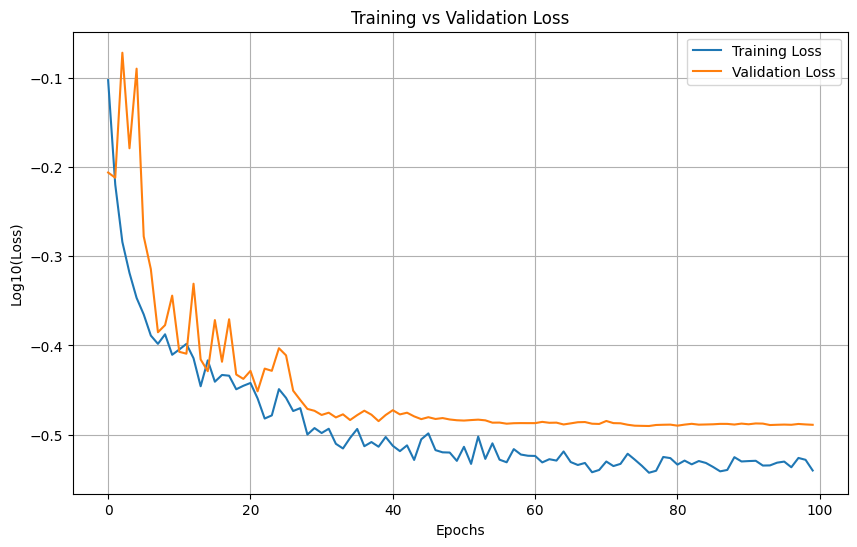

<Figure size 640x480 with 0 Axes>

In [ ]:
def plot_train_val_loss(train_losses: list, val_losses: list):
    """
    Plot training and validation losses.

    Args:
        train_losses (list): A list of training losses.
        val_losses (list): A list of validation losses.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Log10(Loss)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_train_val_loss(np.log10(mean_loss_train),np.log10(mean_loss_test))
# Specify the file path where you want to save the plot
save_path = f'/content/drive/MyDrive/Eversea/Mangrove Dataset/Model/{name_model}/plots_metrics'
file_path = os.path.join(save_path, f'plot_loss_{name_model}.png')

# Save the plot
plt.savefig(file_path)

# Show the plot
plt.show()

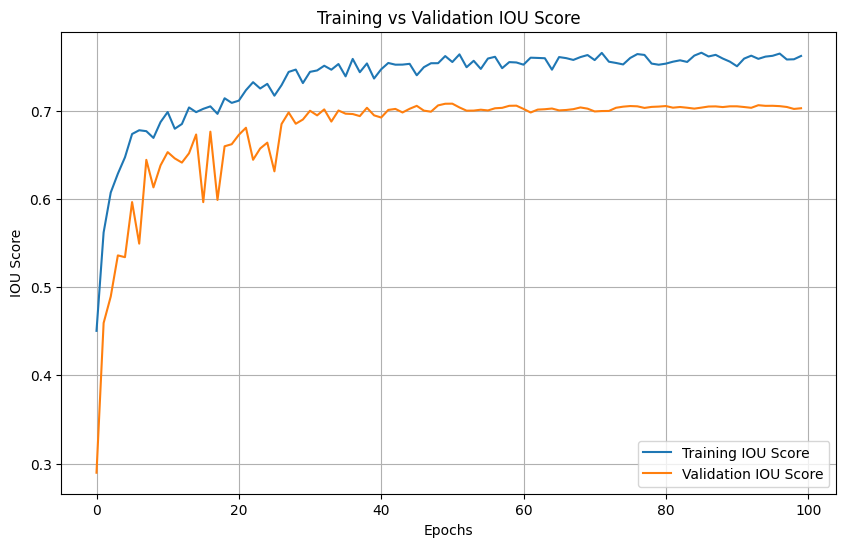

<Figure size 640x480 with 0 Axes>

In [ ]:
def plot_train_val_iou(train_iou: list, test_iou: list):
    """
    Plot training and validation IOU scores.

    Args:
        train_f1 (list): A list of training IOU scores.
        val_f1 (list): A list of validation IOU scores.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_iou, label='Training IOU Score')
    plt.plot(test_iou, label='Validation IOU Score')
    plt.title('Training vs Validation IOU Score')
    plt.xlabel('Epochs')
    plt.ylabel('IOU Score')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_train_val_iou(mean_iou_train, mean_iou_test)
# Specify the file path where you want to save the plot
save_path = f'/content/drive/MyDrive/Eversea/Mangrove Dataset/Model/{name_model}/plots_metrics'
file_path = os.path.join(save_path, f'plot_iou_{name_model}.png')

# Save the plot
plt.savefig(file_path)

# Show the plot
plt.show()

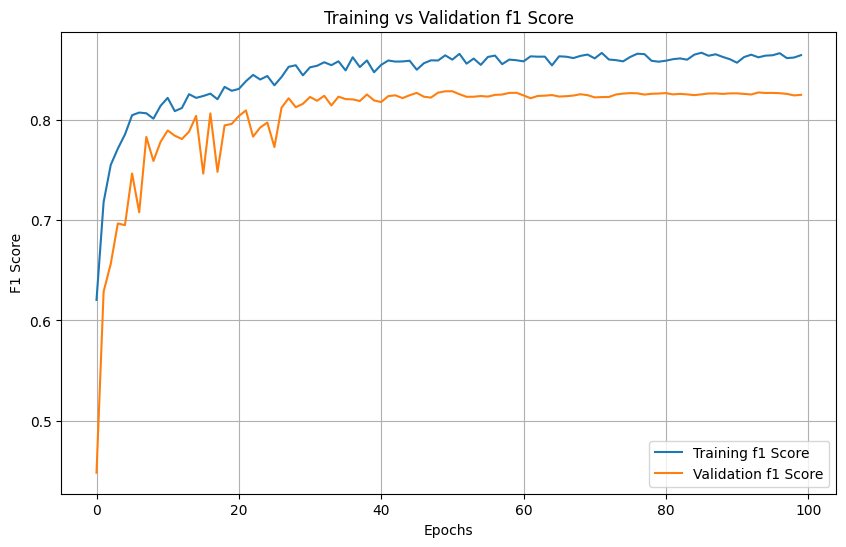

<Figure size 640x480 with 0 Axes>

In [ ]:
def plot_train_val_f1(train_f1: list, test_f1: list):
    """
    Plot training and validation f1 scores.

    Args:
        train_f1 (list): A list of training f1 scores.
        val_f1 (list): A list of validation f1 scores.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_f1, label='Training f1 Score')
    plt.plot(test_f1, label='Validation f1 Score')
    plt.title('Training vs Validation f1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_train_val_f1(mean_f1_train, mean_f1_test)
# Specify the file path where you want to save the plot
save_path = f'/content/drive/MyDrive/Eversea/Mangrove Dataset/Model/{name_model}/plots_metrics'
file_path = os.path.join(save_path, f'plot_f1_{name_model}.png')

# Save the plot
plt.savefig(file_path)

# Show the plot
plt.show()

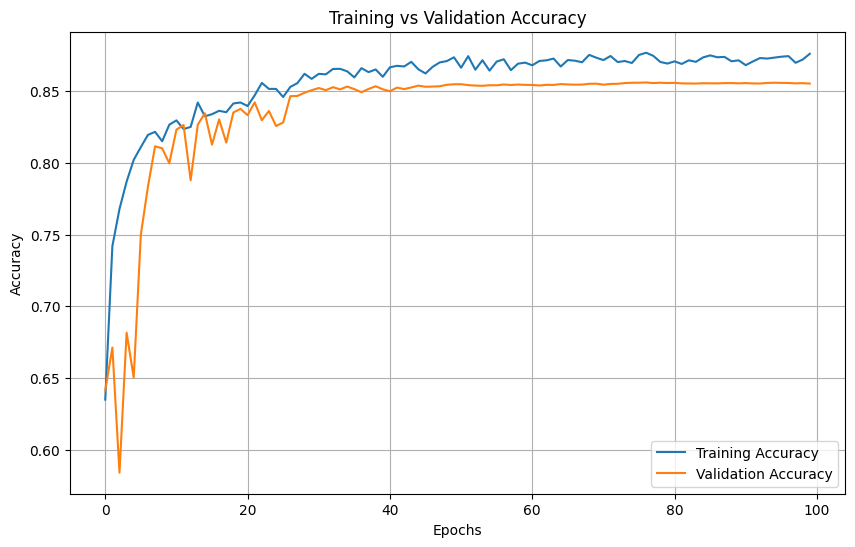

<Figure size 640x480 with 0 Axes>

In [ ]:
def plot_train_val_acc(train_acc: list, test_acc: list):
    """
    Plot training and validation acc scores.

    Args:
        train_acc (list): A list of training acc scores.
        val_acc (list): A list of validation acc scores.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(test_acc, label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_train_val_acc(mean_accuracy_train, mean_accuracy_test)
# Specify the file path where you want to save the plot
save_path = f'/content/drive/MyDrive/Eversea/Mangrove Dataset/Model/{name_model}/plots_metrics'
file_path = os.path.join(save_path, f'plot_acc_{name_model}.png')

# Save the plot
plt.savefig(file_path)

# Show the plot
plt.show()

# Plot segmentation results

## Show inputs

In [ ]:
def plot_augmented_images(test_image: np.ndarray, true_mask: np.ndarray, image_index) -> None:
    """
    Plot augmented RGB, infrared images, NDVI, and mangrove mask side by side.

    Args:
        test_image: A numpy array representing the input image.
        true_mask: A numpy array representing the mangrove mask.

    Returns:
        None. Displays the images in a 2x2 grid.
    """

    # Split the image into bands
    image_rgb = test_image[:,:, [2, 1, 0]]
    image_nir = test_image[:,:, 3]
    image_nir_veg = test_image[:,:, 4]
    image_swir = test_image[:,:, 5]
    ndvi = test_image[:,:, 6]
    ndwi = test_image[:,:, 7]
    ndmi = test_image[:,:, 8]

    # Display bands and true mangrove annotations
    plt.figure(figsize=(15, 10))

    # Plot RGB image
    plt.subplot(2, 4, 1)
    clip_range = (0, 1)
    plt.imshow(2*image_rgb)
    # plt.imshow(np.where(1.3*augmented_rgb>1,1,1.3*augmented_rgb))
    plt.title("Satellite RGB")
    plt.axis('off')

    # Plot NIR image with 'hot' colormap
    plt.subplot(2, 4, 2)
    plt.imshow(image_nir, cmap='hot')
    plt.title("Satellite NIR")
    plt.axis('off')

    # Plot Vegetation NIR image with 'Wistia' colormap
    plt.subplot(2, 4, 3)
    plt.imshow(image_nir_veg, cmap='Wistia')
    plt.title("Satellite Vegetation NIR")
    plt.axis('off')

    # Plot SWIR image with 'cool' colormap
    plt.subplot(2, 4, 4)
    plt.imshow(image_swir, cmap='cool')
    plt.title("Satellite SWIR")
    plt.axis('off')

    # Plot NDVI with 'viridis' colormap
    plt.subplot(2, 4, 5)
    plt.imshow(ndvi, cmap='viridis')
    plt.title("Estimated NDVI")
    plt.axis('off')

    # Plot NDMI with 'summer' colormap
    plt.subplot(2, 4, 6)
    plt.imshow(ndwi, cmap='summer')
    plt.title("Estimated NDWI")
    plt.axis('off')

    # Plot NDVI with 'inferno' colormap
    plt.subplot(2, 4, 7)
    plt.imshow(ndmi, cmap='inferno')
    plt.title("Estimated NDMI")
    plt.axis('off')

    # Plot mangrove mask with 'cividis' colormap
    plt.subplot(2, 4, 8)
    plt.imshow(true_mask, cmap= 'cividis')
    plt.title("Mangrove Locations from GMW")
    plt.axis('off')

    plt.tight_layout()

    # Save images and mask
    save_bands = f'/content/drive/MyDrive/Eversea/Mangrove Dataset/Model/{name_model}/plots_bands'
     # Save the plot
    file_path = os.path.join(save_bands, f'plot_comparison_{image_index}.png')
    plt.savefig(file_path)
    print(image_index)
    plt.show()


In [ ]:
batch = next(iter(dataloader_test))

# Iterate over the batch
image_index = 0
for idx, (test_image, true_mask) in enumerate(zip(batch[0], batch[1])):
    # Extract image and mask from the batch
    test_image_np = test_image.permute(1, 2, 0).cpu().detach().numpy()
    true_mask_np = true_mask.cpu().detach().numpy().squeeze().astype('int')

    plot_augmented_images(test_image_np, true_mask_np, image_index)
    image_index+=1

Output hidden; open in https://colab.research.google.com to view.

## Show predictions

In [ ]:
best_model = smp.MAnet(encoder_name = encoder_name,
    in_channels=num_channels,
    activation = activation,
    classes=1,
)

best_model_path = os.path.join(model_save_path, best_model_filename)
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

In [ ]:
best_model = model

In [ ]:
# SHOW PREDICTIONS ON FULL BATCH

save_comparisons = f'/content/drive/MyDrive/Eversea/Mangrove Dataset/Model/{name_model}/plots_comparison'

with torch.no_grad():
    best_model.eval()
    logits = best_model(batch[0].to(device))

# Counter variable to track iterations
image_index = 0

for image, true_mask, logit in zip(batch[0], batch[1], logits):



    # Predicted mask
    base_mask = logit.cpu().detach().numpy()
    pred_mask = np.where(base_mask>=0.5,1,0).squeeze() # just squeeze classes dim, because we have only one class

    np.save(os.path.join(save_comparisons, f"image_{image_index}.npy"), test_image)
    np.save(os.path.join(save_comparisons, f"true_mask_{image_index}.npy"), true_mask)
    np.save(os.path.join(save_comparisons, f"logit_{image_index}.npy"), base_mask)

    # Brighter image RGB
    clip_range = (0, 1)
    test_image = image.permute(1,2,0).cpu().detach().numpy() # convert CHW -> HWC with permute (transpose for tensors)
    image_rgb = test_image[:,:, [2, 1, 0]] # take RGB bands in the order BGR
    brighter_image_rgb = 3*image_rgb

    # True mask
    true_mask = true_mask[0].cpu().detach().numpy().astype('int')

    # Compute evaluation metrics
    flat_true_mask, flat_pred_mask = true_mask.flatten(), pred_mask.flatten()
    accuracy = accuracy_score(flat_true_mask, flat_pred_mask)
    precision = precision_score(flat_true_mask, flat_pred_mask)
    recall = recall_score(flat_true_mask, flat_pred_mask)
    f1 = f1_score(flat_true_mask, flat_pred_mask)
    iou = jaccard_score(flat_true_mask, flat_pred_mask)


    # Custom colormaps
    cmap_model = mcolors.ListedColormap(['none', 'yellow'])
    cmap_mangrove = mcolors.ListedColormap(['none', 'blue'])

    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

    # Plot 1 - Original image
    axs[0].imshow(brighter_image_rgb)
    axs[0].set_title('Satellite observation from Sentinel-2')
    axs[0].axis('off')  # Turn off axis

    # Plot 2 - Model Output
    axs[1].imshow(brighter_image_rgb)  # Base image
    axs[1].imshow(pred_mask, cmap=cmap_model, alpha=0.5)  # Overlay
    axs[1].set_title(f'Mangrove Position (Model) \n Acc: {accuracy:.2f}, Prec: {precision:.2f}, Rec: {recall:.2f}, F1: {f1:.2f}, IoU: {iou:.2f}')
    axs[1].axis('off')  # Turn off axis

    # Plot 3 - Mangrove Position
    axs[2].imshow(brighter_image_rgb)  # Base image
    axs[2].imshow(true_mask, cmap=cmap_mangrove, alpha=0.5)  # Overlay
    axs[2].set_title('Mangrove Position (GWM)')
    axs[2].axis('off')  # Turn off axis

    file_path = os.path.join(save_comparisons, f'plot_comparison_{image_index}.png')
    plt.savefig(file_path)

    plt.show()

     # Increment index
    image_index += 1





Output hidden; open in https://colab.research.google.com to view.